# Scale all energy
Compare energy scaling to the total from all runs

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
from pylab import *
import scipy.integrate as integrate
#from cmocean import cm as cmo
import matplotlib.gridspec as gridspec
import matplotlib.ticker 
import scipy.stats as stats
import scipy.optimize as optimize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import savgol_filter
from scipy.ndimage import uniform_filter
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [424]:
#Function to find convective and low PV layer depth
def findH(q, Qint, wpbp, z, crit=0.5):
    #low PV layer
    indq = np.where(q>crit*Qint)[0][0]
    H = z[indq]

    #convective layer
    #inds = np.where(np.logical_and(np.logical_and(wpbp>0, z<=H*0.9), z>10))[0]
    zm = 0.5*(z[1:]+z[0:-1])

    inds = np.where(np.logical_and(np.diff(np.signbit(wpbp)), np.logical_and(zm>1, zm<H*0.5)))[0]
    if inds.size == 0:
        inds = np.where(np.logical_and(np.diff(np.signbit(wpbp)), 0.5*(z[1:]+z[0:-1])<H))[0]

    if inds.size == 0:
        print('No Ind ' )
        h = H
    else:
#        inds = [inds[-1]]
        inds = [inds[0]]

        h = z[inds[0]]
    return H, h

## Load all runs

In [425]:
#%% Pick the filename and path
files = [
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p1/snapshots/snapshots_1e-5_0p1_MS.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05_LONG.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p1/snapshots/snapshots_1e-6_0p1_MS.h5',
             '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LNG.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02_V2/snapshots/snapshots_1e-5_0p02_V2_MS.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p06/snapshots/snapshots_1e-6_0p06_MS.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_5e-6_0p02/snapshots/snapshots_5e-6_0p02.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p01/snapshots/snapshots_1e-6_0p01_MS.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p02/snapshots/snapshots_1e-7_0p02_MS.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p005/snapshots/snapshots_1e-7_0p005_MS.h5',
        ]




Ball = []
Htotal = []
htotal=[]
SCALE = []
WPBPI = []
GSPI = []
S2a = []
SPI = []
DISSI = []
TIMEA = []
flagfirst = True
for filename in files:
    print(filename)
    f = h5py.File(filename, 'r')
    print('Loaded')
    # Get the data
    data = list(f['tasks'])

    # Basic parameters
    N = f['tasks']['N'][0,0,0] #Interior stratification (background)
    tht = f['tasks']['tht'][0,0,0] # Slope angle
    print(f'Processing N = {N}, theta = {tht}')

    # Load variables in physical space
    #b = f['tasks']['b'] # Perturbation buoyancy
    v = f['tasks']['v'] # Along-slope direction
    #u = f['tasks']['u'] # Along-slope direction

    vbfr = f['tasks']['VBFrotated'][:,:,:]
    VPWP = f['tasks']['GSProtated'][:,:,:]*1e-4/(N**2*np.sin(tht))
    GSP = f['tasks']['GSProtated'][:,:,:]
    SP = f['tasks']['SP'][:,:,:]
    diss = f['tasks']['DissPartial'][:,:,:]
    #vbfrot = f['tasks']['VBFrotated']
    z = v.dims[2][0][:]
    time = v.dims[0][0][:]
    q = f['tasks']['PV']
  #  wq = f['tasks']['wq']
    print('Begin calcs')
    qm = np.mean(q, axis=1)
    Qo = 1e-4*N**2
    vz = np.gradient(np.mean(v, axis=1), axis=-1)/np.gradient(z)
    #uz = np.gradient(np.mean(u, axis=1), axis=-1)/np.gradient(z)
    #bz = np.gradient(np.mean(b, axis=1), axis=-1)/np.gradient(z)
    # Calculate BEk
    tauy = -1035*1e-4*vz[:,0] #Note that 1e-4 is the viscosity for the DNS
    #taux = -1035*1e-4*uz[:,0]
    
    S2 = N**2*tht**2/1e-8
    Bek = -(tauy/(1035*1e-4)*N**2*np.sin(tht))/(1+S2)

    ws = f['tasks']['ws']
    bs = f['tasks']['bs']
    kx = f['scales/kx'][:]/(2*np.pi) # Inverse wavelengths in cross-front direction
    kcut = np.where(kx<(1/100))[0]
    kcut = kcut[-1]
    vbfs = 2*np.real(np.conj(ws)*bs)
    vbfh = np.sum(vbfs[:,kcut:,:], axis=1)
    
    # Calculate h
    print('Calculations Complete')
    
    nt = time.size
    avgt = 18*2*1
    for i in range(1, nt-avgt+1, avgt):
        ti = range(i, i+avgt)
        qmean = np.mean(qm[ti,:], axis=0) #direct calculation of Q
        
        # Try a direct calculation of H and entrainment
        # Options are to define relative to Qo or as the place the PV flux is 0 (noisy?)
        H, hn = findH(qmean, Qo, np.mean(vbfh[ti,:], axis=0), z, crit=0.75)
        #indq = np.where(qmean>0.75*Qo)[0][0]    
        #H = z[indq] # pick out H
        #vsmooth = np.mean(vbfr[ti,0,:], axis=0)
        #inds = np.where(np.logical_and(vsmooth<0, z<=H))[0]
        # Do high wavenumber version
        #vsmooth = np.mean(vbfh[ti,:], axis=0)
            #inds = np.where(np.logical_and(vsmooth>0, z<=H*0.5))[0]
            #if inds.size == 0:
            #    inds = np.where(np.logical_and(vsmooth>0, z<=H))[0]
        #zm = 0.5*(z[1:]+z[0:-1])
        #inds = np.where(np.logical_and(np.diff(np.signbit(vsmooth)), np.logical_and(zm>0.5, zm<H*0.5)))[0]
        #if inds.size == 0:
        #    inds = np.where(np.logical_and(np.diff(np.signbit(vsmooth)), np.logical_and(zm>1, zm<H)))[0]

        #if inds.size == 0:
        #    print('No Ind: ' + filename)
        #    hn = H
        #else:
        #    inds = [inds[0]]
        #    hn = z[inds[0]]
        htotal.append(hn)
        # Integrate VPWP
        GSPI.append(-integrate.trapz(np.mean(GSP[ti,0,0:indq], axis=0), x=z[0:indq])/(1+S2))
        WPBPI.append(integrate.trapz(np.mean(vbfr[ti,0,0:indq], axis=0), x=z[0:indq])/(1+S2))
        SPI.append(integrate.trapz(np.mean(SP[ti,0,0:], axis=0), x=z[0:]))
        DISSI.append(integrate.trapz(np.mean(diss[ti,0,0:indq], axis=0), x=z[0:indq]))
        S2a.append(S2)
        SCALE.append(np.mean(Bek[ti])*H/2)
        Ball.append(np.mean(Bek[ti]))
        Htotal.append(H)
        TIMEA.append(np.mean(time[ti]))
    f.close()

Htotal = np.array(Htotal)
Ball = np.array(Ball)
GSPI = np.array(GSPI)
WPBPI = np.array(WPBPI)
SCALE = np.array(SCALE)
SPI = np.array(SPI)
DISSI = np.array(DISSI)
htotal = np.array(htotal)
TIMEA = np.array(TIMEA)

/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p1/snapshots/snapshots_1e-5_0p1_MS.h5
Loaded
Processing N = 0.0031622776601683785, theta = 0.1
Begin calcs
Calculations Complete
No Ind 
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05_LONG.h5
Loaded
Processing N = 0.0031622776601683785, theta = 0.05
Begin calcs
Calculations Complete
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p1/snapshots/snapshots_1e-6_0p1_MS.h5
Loaded
Processing N = 0.001, theta = 0.1
Begin calcs
Calculations Complete
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LNG.h5
Loaded
Processing N = 0.0031622776601683785, theta = 0.019999999999999997
Begin calcs
Calculations Complete
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02_V2/snapshots/snapshots_1e-5_0p02_V2_MS.h5
Loaded
Processing N = 0.0031622776601683785, theta = 0.019999999999999993
Begin calcs
Calculations Complete
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p06/sna

In [413]:
def EstimateBStress(f, visc):
    N = f['tasks']['N'][0,0,0] #Interior stratification (background)
    tht = f['tasks']['tht'][0,0,0] # Slope angle
    S2 = N**2*tht**2/1e-8
    
    v = f['tasks']['v'] # Along-slope direction
    z = v.dims[2][0][:]
    time = v.dims[0][0][:]
    vm = np.mean(v, axis=1)
    vz = np.gradient(vm, axis=-1)/np.gradient(z) 
    tauy = -1035*visc*vz[:,0] #Note that 1e-4 is the viscosity for the DNS

    # Calculate the Ekman transport using bottom stress:
    Beka = tauy/(1030*1e-4*(1+S2))*N**2*np.sin(tht)
    
    nt = Beka.shape[0]
    toff = 12
    Ho = 8
    Ent = 1.0 # Entrainment factor...
    H2 = np.zeros((nt, )) 
    for i in range(toff, nt):
        H2[i] = H2[i-1]+(2*(1+S2)*Ent*-Beka[i]/(N**2))*(time[i]-time[i-1])
    
    H = np.sqrt(Ho**2 + H2)
    H[0:toff] = np.nan
    
    qm = f['tasks']['PV']
    qm = np.mean(qm, axis=1)
    return H, Beka, S2, N, qm

In [414]:
# LOAD CI VS SI
#%% Pick the filename and path
CIfilename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05_LONG.h5' #0.1 slope
#CIfilename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p1/snapshots/snapshots_1e-5_0p1_MS.h5' #0.1 slope

SIfilename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LNG.h5' #Ruan case F

visc = 1e-4
Vi = 0.1

SAVEFLAG = False # Turn on to savefigs


f = h5py.File(CIfilename, 'r')
LATSP_CI = -f['tasks']['LSPv'][:,0,:] - f['tasks']['LSPu'][:,0,:]
VERTSP_CI = -f['tasks']['VSPv'][:,0,:] - f['tasks']['VSPu'][:,0,:]
SP_CI = -f['tasks']['SP'][:,0,:]
DISS_CI  = f['tasks']['Diss'][:,0,:]
VBP_CI = f['tasks']['VBFr'][:,0,:]
VBPROT_CI = f['tasks']['VBFrotated'][:,0,:]
ws = f['tasks']['ws']
bs = f['tasks']['bs']
vbfs = 2*np.real(np.conj(ws)*bs)
kx = f['scales/kx'][:]/(2*np.pi) # Inverse wavelengths in cross-front direction
kcut = np.where(kx<1e-2)[0]
kcut = kcut[-1]
VBFH_CI = np.sum(vbfs[:,kcut:,:], axis=1)
H_CI, BEK_CI, S2_CI, N_CI, QM_CI = EstimateBStress(f, visc)
# Domain parameters
z_CI = f['tasks']['u'].dims[2][0][:]
time_CI = f['tasks']['u'].dims[0][0][:]

##### SI RUN  ########
f = h5py.File(SIfilename, 'r')
LATSP_SI = -f['tasks']['LSPv'][:,0,:] - f['tasks']['LSPu'][:,0,:]
VERTSP_SI = -f['tasks']['VSPv'][:,0,:] - f['tasks']['VSPu'][:,0,:]
SP_SI = -f['tasks']['SP'][:,0,:]
DISS_SI  = f['tasks']['Diss'][:,0,:]
VBP_SI = f['tasks']['VBFr'][:,0,:]
VBPROT_SI = f['tasks']['VBFrotated'][:,0,:]
ws = f['tasks']['ws']
bs = f['tasks']['bs']
vbfs = 2*np.real(np.conj(ws)*bs)
kx = f['scales/kx'][:]/(2*np.pi) # Inverse wavelengths in cross-front direction
kcut = np.where(kx<1e-2)[0]
kcut = kcut[-1]
VBFH_SI = np.sum(vbfs[:,kcut:,:], axis=1)
H_SI, BEK_SI, S2_SI, N_SI, QM_SI = EstimateBStress(f, visc)

# Domain parameters
z_SI = f['tasks']['u'].dims[2][0][:]
time_SI = f['tasks']['u'].dims[0][0][:]



## Compare scaling to actual

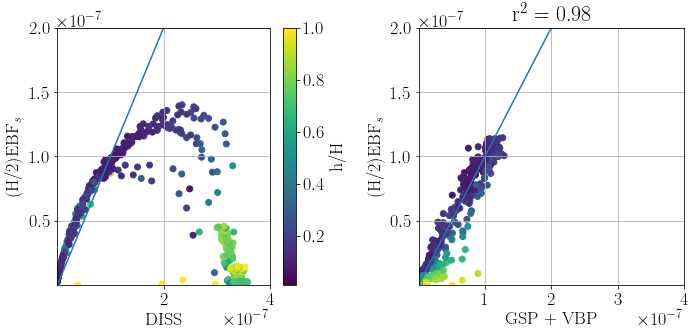

In [209]:
mask = np.where(np.logical_and(htotal/Htotal < 0.8, htotal/Htotal>1e-3))
mask = np.where(TIMEA/86400 > 0)
mask = np.where(SCALE<2e-7)
yvar = (WPBPI + GSPI)*1
#yvar = SCALE
xvar = DISSI
#yvar = Ball*(Htotal-20)**2/2
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ix = ax[0].scatter(xvar[mask], SCALE[mask], c=(htotal/Htotal)[mask])
cb = plt.colorbar(ix, ax=ax[0])
cb.set_label('h/H')
#plt.scatter(-SPI*1, yvar, c=Htotal)
xl = np.max([np.max(np.abs(xvar)), np.max(np.abs(yvar))])*2
xl = np.max(np.abs(xvar[mask]))*1
yl = np.max(np.abs(yvar))*1.5
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
xl = 4e-7
yl = xl/2
ax[0].set_xlim(1e-10, xl)
ax[0].set_ylim(1e-10, yl)
ax[0].plot([0, xl], [0, xl])
ax[0].grid()
ax[0].set_xlabel(r'DISS')
ax[0].set_ylabel(r'(H/2)EBF$_s$')

ax[1].scatter((WPBPI+GSPI)[mask], SCALEA[mask], c=(htotal/Htotal)[mask])
#plt.scatter(-SPI*1, yvar, c=Htotal)
#xl = np.max([np.max(np.abs(xvar)), np.max(np.abs(yvar))])*2
#xl = np.max(np.abs(xvar[mask]))*1
#yl = np.max(np.abs(yvar))*1.5
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
ax[1].set_xlim(1e-10, xl)
ax[1].set_ylim(1e-10, yl)
ax[1].plot([0, xl], [0, xl])
ax[1].grid()
ax[1].set_xlabel(r'GSP + VBP')
ax[1].set_ylabel(r'(H/2)EBF$_s$')
corr = np.corrcoef((WPBPI+GSPI)[mask], np.array(SCALE)[mask])
ax[1].set_title(f'r$^2$ = {corr[1,0]**2:.2}')
plt.tight_layout()
SAVEFLAG=False
if SAVEFLAG:
    plt.savefig(f'./MSFigs/DISSvSCALE.pdf', bbox_inches='tight')

[0.90384513]


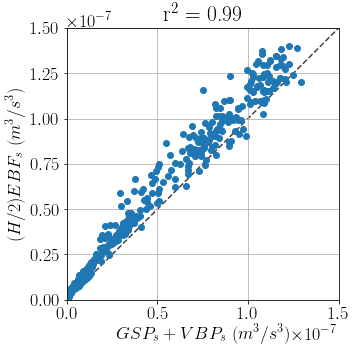

In [334]:
# ONE PANEL

SCALEVAR = SCALE*1
mask = np.where(SCALEVAR<2e-2)
#mask = np.logical_and(SCALEVAR<2e-2, np.logical_and(np.array(S2a)>0.4**2, htotal/Htotal<1))

fig, ax = plt.subplots(1,1, figsize=(5, 5))
#ax.scatter((WPBPI+GSPI)[mask], SCALEVAR[mask], c=(htotal/Htotal)[mask])

#plt.scatter(-SPI*1, yvar, c=Htotal)
#xl = np.max([np.max(np.abs(xvar)), np.max(np.abs(yvar))])*2
#xl = np.max(np.abs(xvar[mask]))*1
#yl = np.max(np.abs(yvar))*1.5
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
xl = 1.5e-7
yl = xl
ax.axis('square')
ax.set_xlim(0, xl)
ax.set_ylim(0, yl)
#plt.colorbar(ix, ax=ax)
ax.plot([0, xl], [0, xl], color='0.25',linestyle='--', zorder=1)
ix = ax.scatter((WPBPI+GSPI)[mask], SCALEVAR[mask], zorder=2)

ax.grid()
#ax.set_xlabel(r'$\frac{1}{1+S^2_\infty} \left[\langle w^\prime b^\prime \rangle - \langle \upsilon^\prime w^\prime\rangle \frac{N^2_\infty\theta}{f}\right] $')
ax.set_xlabel('$GSP_s + VBP_s$  $(m^3/s^3)\;\;\;\;\;\;\;$         ')
ax.set_ylabel(r'$(H/2)EBF_s$ $(m^3/s^3)$')
corr = np.corrcoef((WPBPI+GSPI)[mask], np.array(SCALEVAR)[mask])
ax.set_title(f'r$^2$ = {corr[1,0]**2:.2}')
#plt.tight_layout()

SAVEFLAG=False
if SAVEFLAG:
    plt.savefig(f'./MSFigs/DISSvSCALE.pdf', bbox_inches='tight')
popt, pcov = optimize.curve_fit(f, SCALEVAR[mask], (WPBPI + GSPI)[mask]) # your data x, y to fit
print(popt)

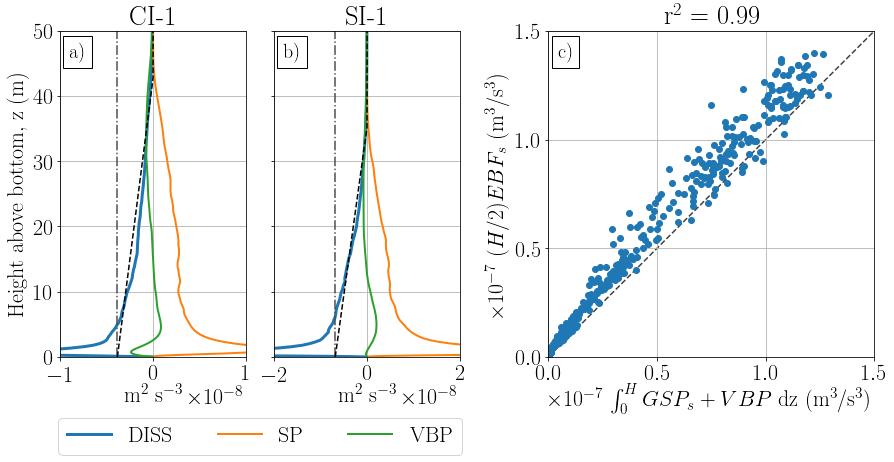

In [423]:
plt.rcParams.update({'font.size': 22})
t1 = 4
t2 = 6
#t1 = 11
#t2 = 13
ti_CI = np.where((time_CI/86400>t1) & (time_CI/86400<t2))[0] # Pick the time range to average over
ti_SI = np.where((time_SI/86400>t1) & (time_SI/86400<t2))[0] # Pick the time range to average over

fig, ax = plt.subplots(1,4,sharey=False, figsize=(15,6), gridspec_kw={'width_ratios': [1, 1,0.05, 2]})
ax[0].plot(np.mean(DISS_CI[ti_CI,:], axis=0), z_CI, linewidth=3)
ax[0].plot(np.mean(SP_CI[ti_CI,:], axis=0), z_CI, linewidth=2)
ax[0].plot(np.mean(VBP_CI[ti_CI,:], axis=0), z_CI, linewidth=2)
ax[0].axvline(np.mean(BEK_CI[ti_CI]), color='0.3', linestyle='-.')
#ax[0].axhline(np.mean(H_CI[ti_CI]))
ax[0].grid()
PEPS = np.mean(BEK_CI[ti_CI])*(1-z_CI/np.mean(H_CI[ti_CI]))
PEPS[z_CI>np.mean(H_CI[ti_CI])] = 0
ax[0].plot(PEPS, z_CI, color='k', linestyle='--')
ax[0].set_ylim(0, 50)
ax[0].set_xlim(-1e-8, 1e-8)
ax[0].set_title('CI-1')
ax[0].set_xlabel('m$^2$ s$^{-3}$')
bb = dict(boxstyle='Square', fc='w')
ax[0].text(0.9*-1e-8,46, 'a)', fontsize=20, bbox=bb)
### SI ####
l1 = ax[1].plot(np.mean(DISS_SI[ti_SI,:], axis=0), z_SI, linewidth=3, label='DISS')
l2 = ax[1].plot(np.mean(SP_SI[ti_SI,:], axis=0), z_SI, linewidth=2, label='SP')
ax[1].plot(np.mean(VBP_SI[ti_SI,:], axis=0), z_SI, linewidth=2, label='VBP')
ax[1].axvline(np.mean(BEK_SI[ti_SI]), color='0.3', linestyle='-.')
#ax[0].axhline(np.mean(H_CI[ti_CI]))
ax[1].grid()
PEPS = np.mean(BEK_SI[ti_SI])*(1-z_SI/np.mean(H_SI[ti_SI]))
PEPS[z_SI>np.mean(H_SI[ti_SI])] = 0
ax[1].plot(PEPS, z_SI, color='k', linestyle='--')
ax[1].set_xlim(-2e-8, 2e-8)
ax[1].set_ylim(0, 50)
ax[1].set_yticklabels([])
ax[1].set_title('SI-1')
ax[1].set_xlabel('m$^2$ s$^{-3}$')
ax[1].text(0.9*-2e-8,46, 'b)', fontsize=20, bbox=bb)

ax[1].legend(bbox_to_anchor=(-0.075, -0.3), loc='lower center', borderaxespad=0., ncol=3)
ax[0].set_ylabel('Height above bottom, z (m)')

#SAVEFLAG = True

# SCATTER PLOT
mask = np.where(SCALEVAR<1.5e-2)
xl = 1.5
yl = xl
ax[3].axis('square')
ax[3].set_xlim(0, xl)
ax[3].set_ylim(0, yl)
ax[3].set_yticks([0, 0.5, 1, 1.5])
#plt.colorbar(ix, ax=ax)
ax[3].plot([0, xl], [0, xl], color='0.25',linestyle='--', zorder=1)
ix = ax[3].scatter(1e7*(WPBPI+GSPI)[mask], 1e7*SCALEVAR[mask], zorder=2)

ax[3].grid()
#ax.set_xlabel(r'$\frac{1}{1+S^2_\infty} \left[\langle w^\prime b^\prime \rangle - \langle \upsilon^\prime w^\prime\rangle \frac{N^2_\infty\theta}{f}\right] $')
ax[3].set_xlabel(r'$\times 10^{-7}$  $\int_0^H GSP_s + VBP\;\mathrm{dz}$  (m$^3$/s$^3$)$\;\;\;\;\;\;\;$         ')
ax[3].set_ylabel(r'$\times 10^{-7}$  $(H/2)EBF_s$ (m$^3$/s$^3$)')

corr = np.corrcoef((WPBPI+GSPI)[mask], np.array(SCALEVAR)[mask])
ax[3].set_title(f'r$^2$ = {corr[1,0]**2:.2}')
ax[3].text(0.03*1.5,1.38, 'c)', fontsize=20, bbox=bb)
ax[2].axis('off')
plt.subplots_adjust(wspace=0.15)
#SAVEFLAG = True
if SAVEFLAG:
    plt.savefig(f'./MSFigs/DISSCombo.pdf', bbox_inches='tight')

In [430]:
def f(x, A): # this is your 'straight line' y=f(x)
    return A*x

mask = np.where(SCALE<1.5e2)

popt, pcov = optimize.curve_fit(f, SCALE[mask], (WPBPI + GSPI)[mask]) # your data x, y to fit
print(popt)

[0.84473899]


In [426]:
np.mean(H_SI[ti])
H, h = findH()

58.99522808526688

In [243]:
np.array(S2a).shape
#np.array(mask).shape
SCALE.shape

(448,)

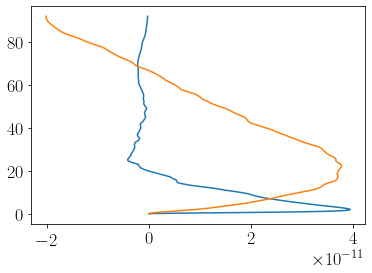

In [38]:
plt.plot(-np.mean(GSP[ti,0,0:indq], axis=0), z[0:indq])
plt.plot(np.mean(vbfr[ti,0,0:indq], axis=0), z[0:indq])